<a href="https://colab.research.google.com/github/woncoh1/era1a7/blob/main/nbs/S7_05_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
Summary of targets, results, and analysis

## Targets
- Reduce over-fitting

## Results
- Best accuracy
    - Train = 99.04 %
    - [x] Test = 99.41 % (>= 99.4 % 3 times)
- [x] Number of Parameters = 4,392
- [x] Number of Epochs = 15

## Analysis
- Let us stop tweaking the model, both the skeleton and the number of parameters, and transform the training set images to make training harder so that later we can boost the test accuracy through more efficient training.
- Amazingly, just by introducing random center crop and random rotation, we suddenly get under-fitting; the test accuracy has even improved!
- It is tempting to just add more parameters to elevate the test accuracy, but I want to get ambitious. Can we train the current model better?

>[Summary](#scrollTo=kjFgf9woqfAE)

>>[Targets](#scrollTo=kjFgf9woqfAE)

>>[Results](#scrollTo=kjFgf9woqfAE)

>>[Analysis](#scrollTo=kjFgf9woqfAE)

>[Device](#scrollTo=7QlJ9s_43tj4)

>>[Colab](#scrollTo=_qZEo7Ty13uh)

>>[Pytorch](#scrollTo=30q5EOnt11t3)

>[Data](#scrollTo=IZlN9TTM3yVC)

>>[Transform](#scrollTo=lDnD-zELz8as)

>>[Dataset](#scrollTo=N4NSVJ0DwivZ)

>>[DataLoader](#scrollTo=vb2R5ZBFzi08)

>>[Inspect](#scrollTo=WD-_p0o7PQN_)

>[Model](#scrollTo=5v1EC4vo3upW)

>[Trainer](#scrollTo=_KvOD_jk3zrp)

>[Evaluate](#scrollTo=BoqfYvTXUPFb)



In [1]:
!git clone https://github.com/woncoh1/era1a7.git

Cloning into 'era1a7'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 67 (delta 36), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (67/67), 22.73 KiB | 802.00 KiB/s, done.


In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary

from era1a7 import data, models, engine, utils

In [3]:
torch.manual_seed(1)

# Device

## Colab
Runtime
- Hardware accelerator: GPU
- GPU type: T4
- Runtime shape: Standard

## Pytorch
- cpu
- cuda
- mps

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data
- Transforms
- Batch size

## Transform
- https://pytorch.org/vision/master/transforms.html
- https://pytorch.org/vision/stable/auto_examples/plot_transforms.html

In [5]:
transform = {
    'train': transforms.Compose([
        transforms.RandomApply([transforms.CenterCrop(22)], p=0.1), # Crop
        transforms.Resize((28, 28)), # Resize after crop
        transforms.RandomRotation((-15., 15.)), # Rotation
        transforms.ToTensor(), # Standardization
        transforms.Normalize((0.1307,), (0.3081,)), # Normalization
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]),
}

## Dataset

In [6]:
dataset = data.get_dataset(transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 72772722.37it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 122235816.17it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25277473.22it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15301629.53it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## DataLoader

In [7]:
params_dataloader = {
    'batch_size': 128,
    'shuffle': True,
    'num_workers': 0,
    'pin_memory': True,
}

In [8]:
loader = data.get_dataloader(dataset, params_dataloader)

## Inspect

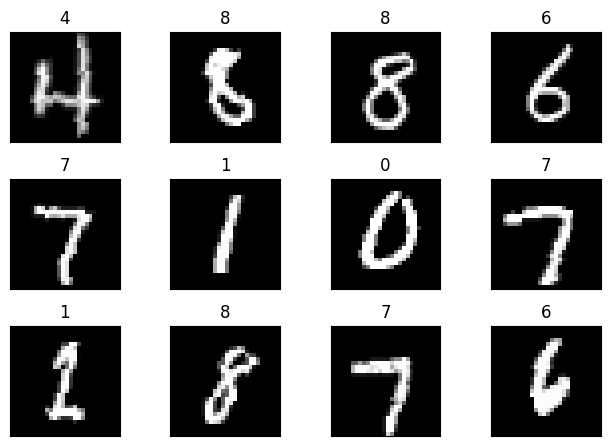

In [9]:
utils.inspect_batch(loader['train'])

# Model

In [10]:
criterion = F.nll_loss
model = models.Model3().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]             144
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
             ReLU-10           [-1, 16, 24, 24]               0
      BatchNorm2d-11           [-1, 16, 24, 24]              32
        Dropout2d-12           [-1, 16, 24, 24]               0
           Conv2d-13           [-1, 16, 22, 22]             144
             ReLU-14           [-1, 16,

# Trainer

In [11]:
params_trainer = {
    'num_epochs': 15,
}
params_optimizer = {
    'lr': 0.5,
    'momentum': 0.9,
}
params_scheduler = {
    'step_size': 10,
    'gamma': 0.1,
    'verbose': True,
}

optimizer = optim.SGD(model.parameters(), **params_optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, **params_scheduler)

results = engine.train(
    device,
    loader['train'],
    loader['test'],
    model,
    criterion,
    optimizer,
    scheduler,
    params_trainer['num_epochs'],
)

Adjusting learning rate of group 0 to 5.0000e-01.


  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00185, Accuracy = 92.51%, Epoch = 1
Test : Loss = 0.00101, Accuracy = 96.01%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00074, Accuracy = 97.05%, Epoch = 2
Test : Loss = 0.00044, Accuracy = 98.17%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00063, Accuracy = 97.45%, Epoch = 3
Test : Loss = 0.00035, Accuracy = 98.60%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00057, Accuracy = 97.72%, Epoch = 4
Test : Loss = 0.00044, Accuracy = 98.22%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00051, Accuracy = 97.96%, Epoch = 5
Test : Loss = 0.00030, Accuracy = 98.76%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00049, Accuracy = 98.08%, Epoch = 6
Test : Loss = 0.00031, Accuracy = 98.83%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00045, Accuracy = 98.19%, Epoch = 7
Test : Loss = 0.00032, Accuracy = 98.70%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00044, Accuracy = 98.27%, Epoch = 8
Test : Loss = 0.00024, Accuracy = 99.01%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-01.
Train: Loss = 0.00040, Accuracy = 98.38%, Epoch = 9
Test : Loss = 0.00047, Accuracy = 98.21%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00042, Accuracy = 98.29%, Epoch = 10
Test : Loss = 0.00029, Accuracy = 98.85%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00030, Accuracy = 98.81%, Epoch = 11
Test : Loss = 0.00016, Accuracy = 99.36%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00027, Accuracy = 98.92%, Epoch = 12
Test : Loss = 0.00016, Accuracy = 99.41%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00025, Accuracy = 98.94%, Epoch = 13
Test : Loss = 0.00016, Accuracy = 99.40%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00025, Accuracy = 99.01%, Epoch = 14
Test : Loss = 0.00017, Accuracy = 99.40%



  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Train: Loss = 0.00024, Accuracy = 99.04%, Epoch = 15
Test : Loss = 0.00016, Accuracy = 99.39%



# Evaluate

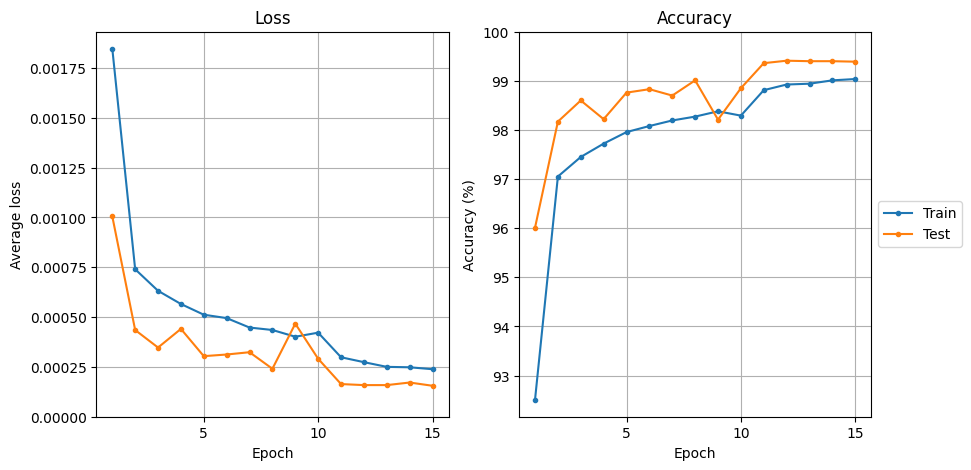

In [12]:
utils.plot_curves(results)